In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import numpy as np

from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
import seaborn as sns

/home/mojo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.5)

In [3]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).view(-1,1)

# X_test = torch.FloatTensor(X_test)
# y_test = torch.FloatTensor(y_test).view(-1,1)

train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)
# test_data = torch.utils.data.TensorDataset(X_test, y_test)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=500)

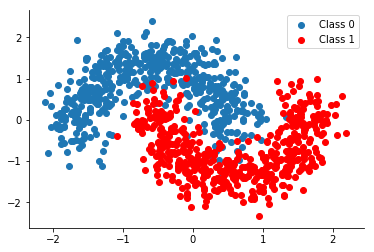

In [4]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()

In [5]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = torch.FloatTensor(grid.reshape(2, -1).T)
dummy_out = torch.tensor(np.ones(grid_2d.shape))

In [6]:
test_data = torch.utils.data.TensorDataset(grid_2d, dummy_out)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10000)

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(2, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50,2, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import sgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr = 1e-4



batch_size = 32
dataset_size= 500.

network = Model()
criterion = nn.BCEWithLogitsLoss(size_average=False)

optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)

#evaluate = evaluation(test_loader, 4.5, X_train_mean, X_train_std, y_train_mean, y_train_std)

losses_sgld = []
test_rmse = []
log_lik_sgld = []
n_samples = 200
t = 1.
n = 0
predictions = torch.zeros(10000,n_samples)

for epoch in range(200):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)
        one_hot = torch.zeros(x.size(0),2).scatter_(1,y.view(-1,1).long(),1)

        network.zero_grad()
        output = network(x)
        loss = criterion(output, one_hot)
        loss.backward()
        optim.step()


       
        running_loss += loss * batch_size / dataset_size


        if (t >= 300) & (t % 10 == 0) & (n < n_samples):
            accuracy = 0
            with torch.autograd.no_grad():
                for x, y in iter(test_loader):
                    output = network(x)
                    output = F.sigmoid(output)
                    prediction = output.data.max(1)[1].view(-1,1)
                    
                    #accuracy = torch.sum(prediction.eq(y.long())).float() / 500
                    predictions[:,n] = prediction.view(-1,)
                    print("Accuracy: {:.4f}".format(accuracy))
                    n += 1
#            rmse, log_lik, predictions = evaluate.fn(network)

#                rmse, log_lik = evaluate(network, test_loader, tau, T, y_train_mean, y_train_std)
#            test_rmse.append(rmse)
#            log_lik_sgld.append(log_lik)
        
        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().mean(1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

In [ ]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().std(axis=1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr = 1e-2
alpha = 0.99



batch_size = 32
dataset_size= 500.

network = Model()
criterion = nn.BCEWithLogitsLoss(size_average=False)

optim = psgld.optim.psgld(network, lr, alpha,lambda_, batch_size, dataset_size)

#evaluate = evaluation(test_loader, 4.5, X_train_mean, X_train_std, y_train_mean, y_train_std)

n_samples = 200
t = 1.
n = 0
predictions = torch.zeros(10000,n_samples)

for epoch in range(200):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)
        one_hot = torch.zeros(x.size(0),2).scatter_(1,y.view(-1,1).long(),1)

        network.zero_grad()
        output = network(x)
        loss = criterion(output, one_hot)
        loss.backward()
        optim.step()


       
        running_loss += loss * batch_size / dataset_size


        if (t >= 300) & (t % 10 == 0) & (n < n_samples):
            accuracy = 0
            with torch.autograd.no_grad():
                for x, y in iter(test_loader):
                    output = network(x)
                    output = F.sigmoid(output)
                    prediction = output.data.max(1)[1].view(-1,1)
                    
                    #accuracy = torch.sum(prediction.eq(y.long())).float() / 500
                    predictions[:,n] = prediction.view(-1,)
                    print("Accuracy: {:.4f}".format(accuracy))
                    n += 1
#            rmse, log_lik, predictions = evaluate.fn(network)

#                rmse, log_lik = evaluate(network, test_loader, tau, T, y_train_mean, y_train_std)
#            test_rmse.append(rmse)
#            log_lik_sgld.append(log_lik)
        
        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().mean(1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

In [ ]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().std(axis=1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [ ]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr = 1e-2



batch_size = 32
dataset_size= 500.

network = Model()
criterion = nn.BCEWithLogitsLoss(size_average=False)

optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon= 1e-2, l2=1e-3, invert_every=1)




n_samples = 200
t = 1.
n = 0
predictions = torch.zeros(10000,n_samples)

for epoch in range(200):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)
        one_hot = torch.zeros(x.size(0),2).scatter_(1,y.view(-1,1).long(),1)
        
        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = criterion(output, one_hot)
        loss.backward()
        optim.step()


       
        running_loss += loss * batch_size / dataset_size


        if (t >= 300) & (t % 10 == 0) & (n < n_samples):
            accuracy = 0
            with torch.autograd.no_grad():
                for x, y in iter(test_loader):
                    output = network(x)
                    output = F.sigmoid(output)
                    prediction = output.data.max(1)[1].view(-1,1)

                    predictions[:,n] = prediction.view(-1,)
                    print("Accuracy: {:.4f}".format(accuracy))
                    n += 1

        
        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

In [ ]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().mean(1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)

cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

In [ ]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().std(axis=1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [21]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgld

import model



if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")



lambda_ = 1.
lr = 1e-2



batch_size = 32
dataset_size= 500.

network = Model()
criterion = nn.BCEWithLogitsLoss(size_average=False)

optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=1., v=0., lambda_=1., epsilon= 2e-7, l2=1e-3, invert_every=1)




n_samples = 200
t = 1.
n = 0
predictions = torch.zeros(10000,n_samples)

for epoch in range(200):

    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)
        one_hot = torch.zeros(x.size(0),2).scatter_(1,y.view(-1,1).long(),1)
        
        optim.update_curvature(x)

        network.zero_grad()
        output = network(x)
        loss = criterion(output, one_hot)
        loss.backward()
        optim.step()


       
        running_loss += loss * batch_size / dataset_size


        if (t >= 300) & (t % 10 == 0) & (n < n_samples):
            accuracy = 0
            with torch.autograd.no_grad():
                for x, y in iter(test_loader):
                    output = network(x)
                    output = F.sigmoid(output)
                    prediction = output.data.max(1)[1].view(-1,1)

                    predictions[:,n] = prediction.view(-1,)
                    print("Accuracy: {:.4f}".format(accuracy))
                    n += 1

        
        t += 1.
    print("Epoch {:d} - loss: {:.4f}".format(epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 47.6759
Epoch 1 - loss: 50.9128
Epoch 2 - loss: 51.9755
Epoch 3 - loss: 47.2265
Epoch 4 - loss: 47.4646
Epoch 5 - loss: 46.5890
Epoch 6 - loss: 44.7935
Epoch 7 - loss: 44.4051
Epoch 8 - loss: 46.5551
Epoch 9 - loss: 45.5385
Epoch 10 - loss: 46.6947
Epoch 11 - loss: 46.2286
Epoch 12 - loss: 46.4062
Epoch 13 - loss: 46.7750
Epoch 14 - loss: 45.5474
Epoch 15 - loss: 44.1373
Epoch 16 - loss: 42.5576
Epoch 17 - loss: 43.9541
Accuracy: 0.0000
Epoch 18 - loss: 45.9428
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 19 - loss: 46.4860
Accuracy: 0.0000
Epoch 20 - loss: 46.9235
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 21 - loss: 47.3012
Accuracy: 0.0000
Epoch 22 - loss: 47.0343
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 23 - loss: 48.4332
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 24 - loss: 51.7439
Accuracy: 0.0000
Epoch 25 - loss: 56.6267
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 26 - loss: 56.5539
Accuracy: 0.0000
Epoch 27 - loss: 53.2938
Accuracy: 0.0000
Accuracy: 0.0000
Epoch 28 - loss: 51.8

Epoch 185 - loss: 182.1460
Epoch 186 - loss: 174.2875
Epoch 187 - loss: 155.0767
Epoch 188 - loss: 153.5574
Epoch 189 - loss: 170.6039
Epoch 190 - loss: 190.2344
Epoch 191 - loss: 198.9799
Epoch 192 - loss: 194.0332
Epoch 193 - loss: 181.4428
Epoch 194 - loss: 173.7110
Epoch 195 - loss: 179.6034
Epoch 196 - loss: 193.9431
Epoch 197 - loss: 186.7303
Epoch 198 - loss: 190.5184
Epoch 199 - loss: 192.8568


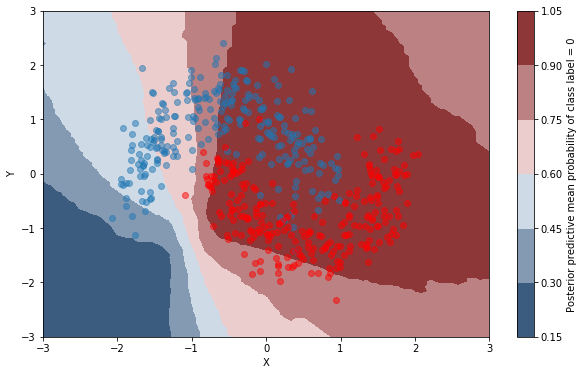

In [19]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().mean(1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

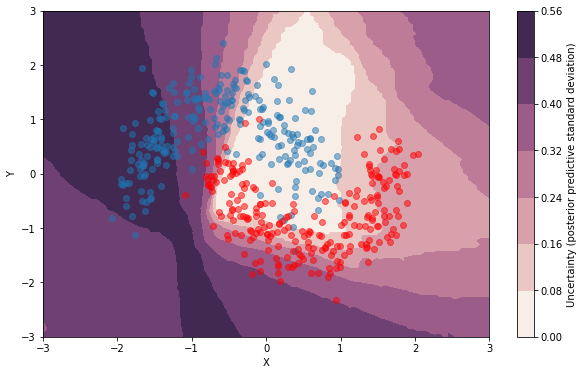

In [20]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(grid[0, :], grid[1, :], predictions.numpy().std(axis=1).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], alpha=0.5)
ax.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='r', alpha=0.5)
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');